In [1]:
import numpy as np
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})

import scipy.linalg as spl
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
import xarray as xr

from waveeqn1D import WaveEquation

from utils import *
import nfft
import time

# Solving for the 2D, continously stratified internal wave equation by Fourier transforming in $x$ & time

The vertical velocity of an internal wave in the Boussinesq approximation in a continuously stratified medium obeys
$$\dfrac{\partial^2}{\partial t^2}\left(\dfrac{\partial^2}{\partial x^2}+\dfrac{\partial^2}{\partial z^2}\right) w + N(z)^2\dfrac{\partial^2 w}{\partial x^2} = 0$$
One can decompose into modes of the form $w(x,z,t) = \Re\left[ \tilde w(z)e^{i(kx-\omega t)} \right]$. $\tilde w$, with the vertical structure verifying $$\dfrac{\mathrm{d}^2 \tilde w}{\mathrm{d} z^2} + k^2 \left(\dfrac{N(z)^2}{\omega^2}-1\right)\tilde w = 0$$
with Dirichlet BCs on both ends. The above equation is recast as a generalized eigenvalue problem of the form
$$\mathbf{A}\tilde w = \lambda\mathbf{B} \tilde w$$
where $\mathbf{A} = \mathbf{D}_2 - k^2 \mathbf{I}$ ($\mathbf{D}_2$ is the discrete second derivative in $z$), $\mathbf{B} = k^2\mathrm{diag}(N(z)^2)$ and $\lambda = -\omega^{-2}$.

The full solution reads, in discretized terms, $$ w(x,z,t) = \Re\sum_{n=1}^{N_x} e^{ik_nx}\sum_{l=1}^{N_z}\tilde w_{n,l}(z)\left[C_{n,l}^+e^{i\omega_{n,l}t} + C_{n,l}^-e^{-i\omega_{n,l}t}\right]$$

The $C_{n,l}^{+/-}$ are given by the initial condition. One can show that with initial conditions $w(x,z,0) = w_0(x,z)$ and $\partial_t w(x,z,0) = 0$, $C_{n,l}^+=C_{n,l}^- = C_{n,l}/2$, where $C_{n,l}$ is obtained by solving, for each $n$, the linear system
$$\sum_{l=1}^{N_z} C_{n,l}\tilde w_{n,l} = \hat w_0(k_n)$$
and $\hat w_0$ is the partial Fourier transform in $x$ of the initial condition $w_0(x,z)$.

In [53]:
class InternalWaveEquation:
    def __init__(self,Lx=10e3,Nx=1000,Lz=1e3,Nz=100,Lt=3600,Nt=60,z0=100,sigma_z=20):
        #x mesh
        self.L_x = Lx #Length of the domain in x [m]
        self.N_x = Nx #Number of points in x
        self.X = np.linspace(0,self.L_x,self.N_x)
        self.dx = self.X[1]-self.X[0] #horizontal discretization
        self.K = 2*np.pi*np.fft.fftfreq(self.N_x,self.dx)
        self.z0 = z0
        self.sigma_z = sigma_z
        
        #z mesh
        self.L_z = Lz #Depth of the domain [m]
        self.N_z = Nz #Number of points in z
        self.Z = np.linspace(0,self.L_z,self.N_z)
        self.dz = self.Z[1]-self.Z[0] #vertical discretization
        
        #Temporal mesh 
        self.L_t = Lt #Length of the integration
        self.N_t = Nt #Number of points in time
        self.T = np.linspace(0,self.L_t,self.N_t)
        self.dt = self.T[1]-self.T[0] #temporal discretization
        
    def I(self,x,z):
        x0=5e3;z0=200.
        zwidth=40
        xwidth=200
        return np.exp(-(z-z0)**2/2/zwidth**2-(x-x0)**2/2/xwidth**2)
        
    def stratification(self,z):
        # return 0.01*z**0
        return 0.01 + np.exp(-((z-self.z0)**2)/(2*self.sigma_z**2))*0.1
        
    def set_eigenmodes(self,k): 
        """Compute the eigenmodes w_tilde_kn and associated eigenvalues. Could be sped up with sparse matrices & selecting leading vertical modes only"""
        D2 = make_D_fornberg(self.Z,2,npoints=5)
        A = D2 - k**2*np.eye(self.N_z)
        B = k**2 * np.diag(self.stratification(self.Z))
        
        A[0]=0.;A[0,0]=1.;A[-1]=0.;A[-1,-1]=1.
        B[0]=0.;B[0,0]=1.;B[-1]=0.;B[-1,-1]=1.
        
        minusomegasm2,wtildes=spl.eig(A,B) # The eigenvalues correspond to -omega^-2, where omega is the eigenfrequency of each mode
        sortidx = np.argsort(minusomegasm2)
        cutoff=-2 # Throw away non-oscillatory modes
        omegasm2 = -np.real(minusomegasm2[sortidx[:cutoff]])
        wtildes = wtildes[:,sortidx[:cutoff]]
        
        return (1./np.sqrt(omegasm2), # Vector of size N_z-2
                wtildes         ) # Matrix of shape (N_z,N_xz2)
        
    def set_all_eigenmodes(self):
        self.wtildes = np.zeros((self.N_x,self.N_z-2,self.N_z)) # Dimensions: k,n,z
        self.omegas  = np.zeros((self.N_x,self.N_z-2))          # Dimensions: k,n
        for ik,k in enumerate(self.K):
            omegas,wtildes = self.set_eigenmodes(k)
            self.wtildes[ik] = wtildes.transpose()
            self.omegas[ik]  = omegas
    
    def set_initcond_matrix(self,k):
        ik = list(self.K).index(k)
        self.M = self.wtildes[ik].transpose()[1:-1]
        
    def set_initcond_rhs(self,k):
        """Setup the right-hand side of the initial condition equation (eta(t=0) set by self.I and deta/dt(t=0)=0)"""
        ik = list(self.K).index(k)
        w0 = self.I(self.X[:,None],self.Z[None,:])[:,1:-1]
        self.rhs = np.fft.fft(w0,axis=0)[ik]
        
    def integrate(self):
        %time self.set_all_eigenmodes()
        what = 1j*np.zeros((self.N_x,self.N_z,self.N_t))
        for ik,k in enumerate(self.K):
            if ik == 0:
                continue
            self.set_initcond_matrix(k)
            self.set_initcond_rhs(k)
            # Get mode coefficients
            Cn = spl.solve(self.M,self.rhs)
            # define evaluation points for the nonuniform inverse fft
            fk = self.omegas[ik]*self.dt/2/np.pi        
            
            # Perform the nonuniform inverse fft in z, grid point by grid point
            for iz in range(self.N_z):
                #what[ik,iz,0] =  (Cn*self.wtildes[ik,:,iz]).sum()
                what[ik,iz] =  nfft.nfft_adjoint(-fk, Cn*self.wtildes[ik,:,iz]*np.exp(-2*np.pi*1j*(self.N_t//2)*fk), self.N_t)
                what[ik,iz]+=  nfft.nfft_adjoint( fk, Cn*self.wtildes[ik,:,iz]*np.exp( 2*np.pi*1j*(self.N_t//2)*fk), self.N_t)
        
        # Perform the inverse fft in x
        self.w = xr.DataArray(np.real(np.fft.ifft(what,axis=0)),coords={'x':self.X,'z':self.Z,'time':self.T},dims=['x','z','time'])
        self.w_init = xr.DataArray(self.I(self.X[:,None],self.Z[None,:]),coords={'x':self.X,'z':self.Z},dims=['x','z'])
        

In [54]:
iwave = InternalWaveEquation(Lt=100,Nt=30,Nx=1000)

(1000.0, 0.0)

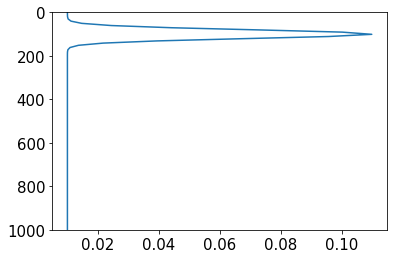

In [55]:
plt.figure()
plt.plot(iwave.stratification(iwave.Z),iwave.Z)
plt.ylim([1000, 0])

In [56]:
%time iwave.integrate()

/var/folders/xs/yyr6v47n4wb__gjztrdlbv6w0000gr/T/ipykernel_24810/4183778512.py:49: RuntimeWarning: invalid value encountered in sqrt
  return (1./np.sqrt(omegas2), # Vector of size N_z-2


CPU times: user 8.68 s, sys: 203 ms, total: 8.88 s
Wall time: 11.4 s
CPU times: user 1min 26s, sys: 1.37 s, total: 1min 28s
Wall time: 1min 37s


/var/folders/xs/yyr6v47n4wb__gjztrdlbv6w0000gr/T/ipykernel_24810/2997684355.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


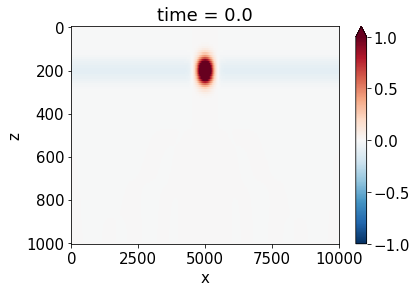

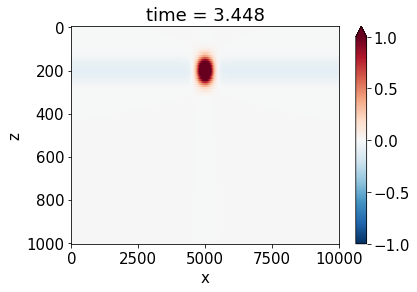

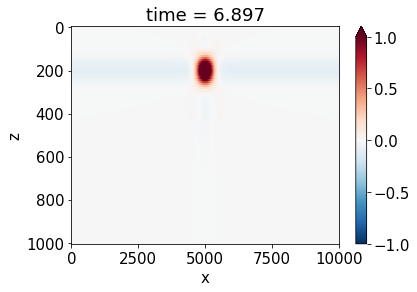

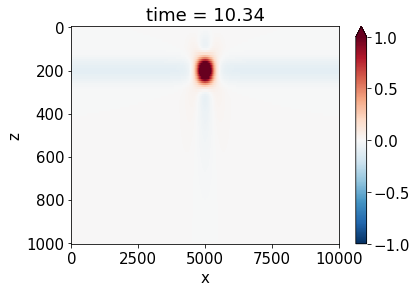

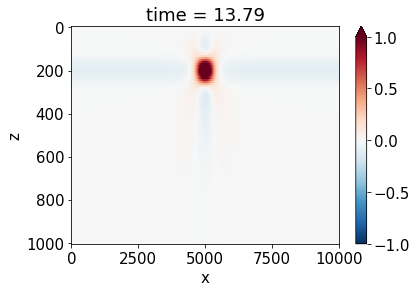

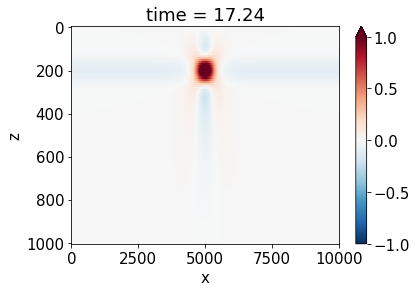

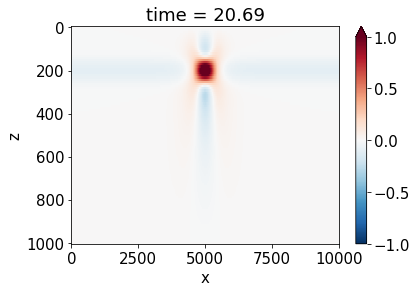

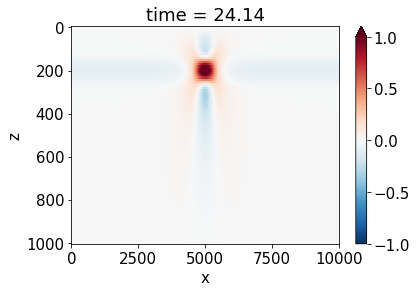

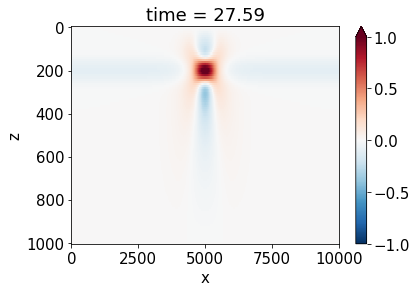

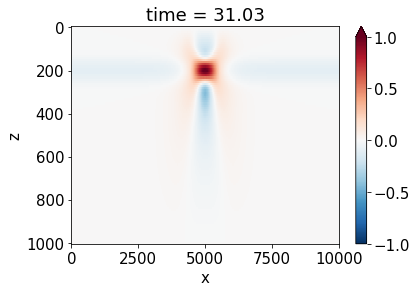

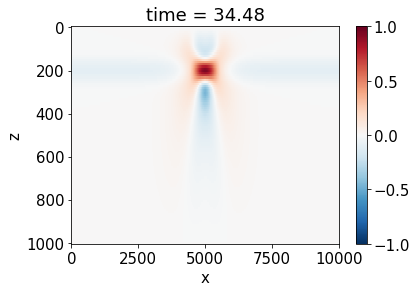

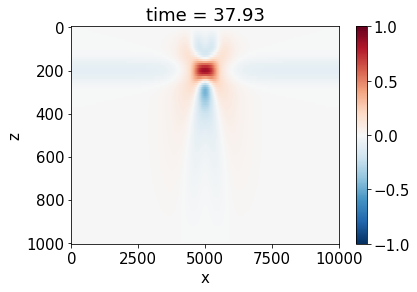

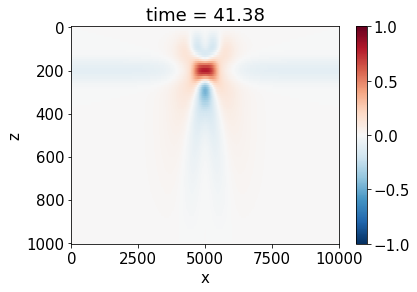

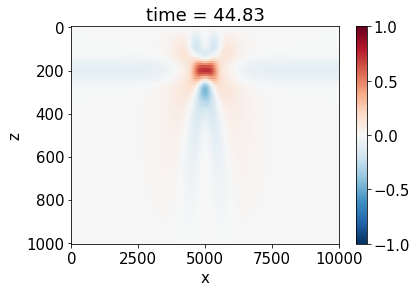

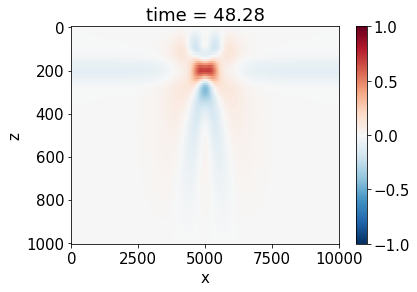

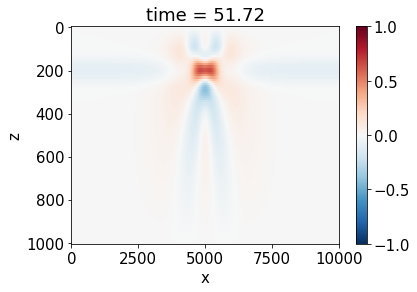

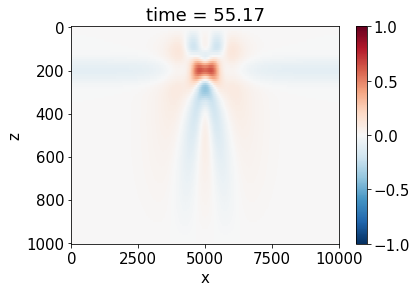

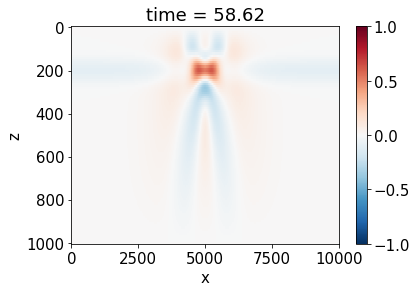

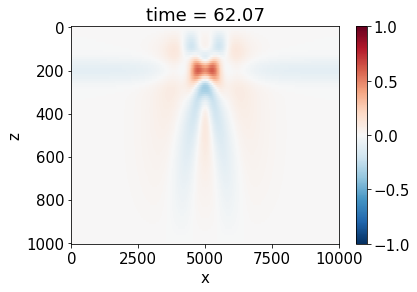

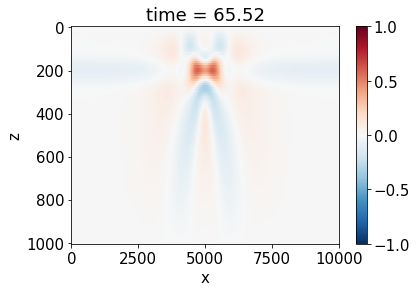

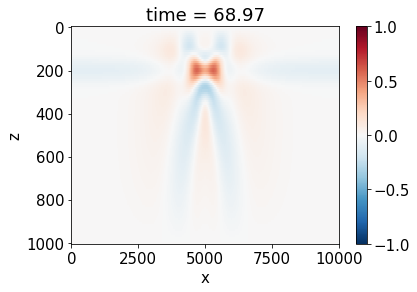

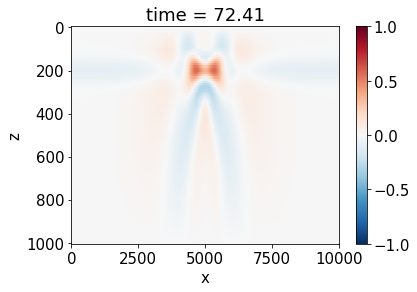

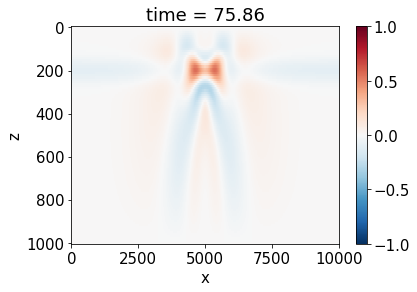

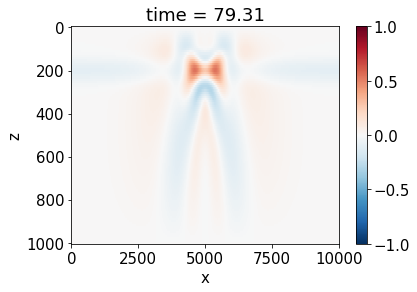

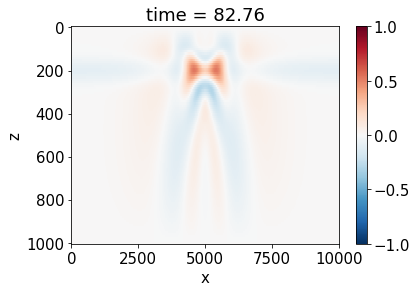

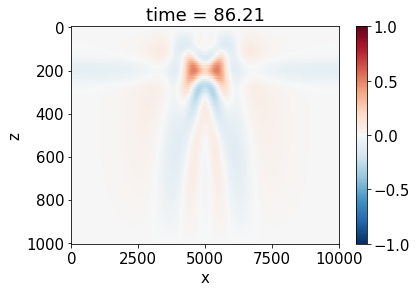

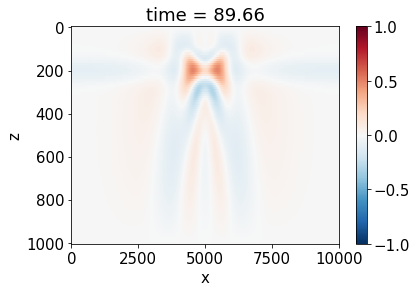

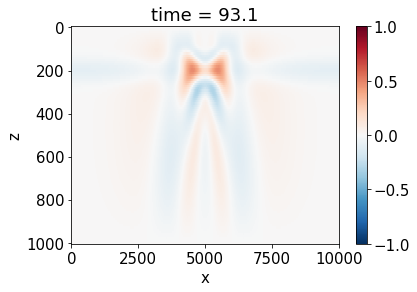

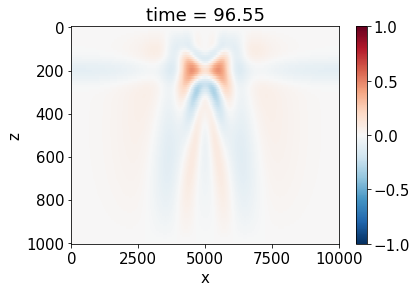

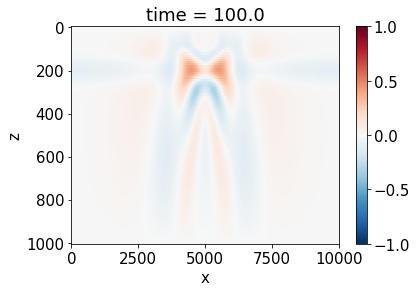

In [57]:
for t in range(len(iwave.w.time)):
    plt.figure()
    iwave.w.isel(time=t).plot(y='z',yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r)

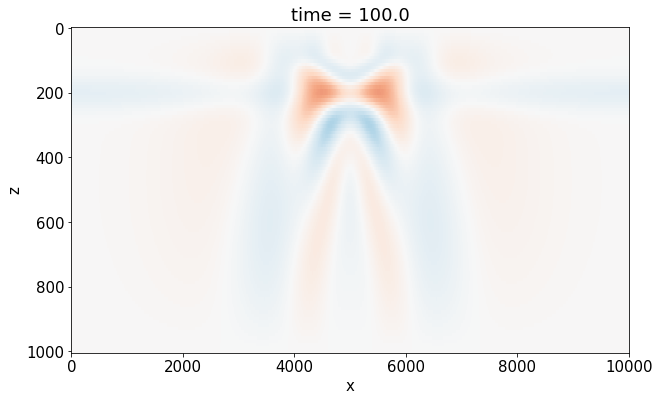

In [61]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

def update(t):
    ax.clear()
    iwave.w.isel(time=t).plot(y='z',yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r, add_colorbar=False)

im_ani = animation.FuncAnimation(fig, update, frames=range(iwave.N_t),interval=100)
im_ani.save("presvid.mp4")